<a href="https://colab.research.google.com/github/JoshStrong/2LayerMLP/blob/master/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries

import pandas as pd
import seaborn as sns
import os
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as dset
from torchvision.utils import save_image

#PCA methodology:
With PCA, we wish to rerepresent a dataset with a large number of $p$ variables $X_1, X_2, ..., X_p $ to one with a smaller number of $k$ variables, $Y_1, Y_2, ..., Y_k$ with $k << p$. These new variables are designed to contain as much "information" as possible (here information represents variance), whilst being uncorrelated such that additional variables do not add duplicate information. An additional constraint is that these new $Y$ variables are designed to be linear combinations of the original $X$ variables, i.e. $Y_i = a_{i1} X_1 + ... + a_{ip} X_p$ where $a_{ij} \in \Re$ $\forall i,j$. \\

### The first principle component:
Find $Y_1$ s.t. 
\begin{equation}
Y_1 = a_{11}X_1 + ... + a_{1p} X_p = \bf{a}^TX
\end{equation}
has maximal variance subject to $\bf{a_1^Ta_1} = 1$. We restrict the dot products of the coefficients to be 1 since it is possible to simply increase the variance by increasing these coefficients, which is not what we are looking to do. The estimated variance of $Y_1$ is given by
\begin{align}
\hat{var}(Y_1) &= \hat{var}(a_{11}X_1 + ... + a_{1p} X_p) \\
          &= \sum_{i,j=1}^{p} a_{1i}a_{1j} S_{ij} \\
          &= \bf{a^T_1Sa_1}
\end{align}
where $\bf{S}$ is the sample covariance matrix of $X$. \\
Maximising this through the method of Lagrange multipliers yields
\begin{equation}
\frac{\partial[\bf{a^T_1Sa_1} - \lambda_1(a^T_1a_1 - 1)]}{\partial a_1} = 0,
\end{equation}
giving $2\bf{Sa_1} - 2\lambda_1 a_1 = 0 \equiv (\bf{S}-\lambda_1I)a_1 = 0$. It can be seen that, through this, $\lambda_1$ is the largest eigenvalue of $\bf{S}$ and $\bf{a}_1$ the normalised eigenvector corresponding to $\lambda_1$.

### Subsequent principle components:
The same methodology is repeated for obtaining subsequent principle components, with an additional constraint that each additional component is independent to the previous one. This is achieved through (using the second principle component as an example) $\bf{a^T_1a_2 = a^T_2a_1 = 0}$. Again, using the method of Legrange multipliers, we have
\begin{equation}
\frac{\partial[\bf{a^T_2Sa_2} - \lambda_2(a^T_2a_2 - 1) - \theta_2 a^T_2a_1]}{\partial a_2} = 0,
\end{equation}
giving us $2\bf{Sa_2} - 2\lambda_2a_2 - \theta_2a_1 = 0 \equiv (S - \lambda_2I)a_2 = \frac{1}{2}\theta_2 a_1$. Through previously described conditions, this reduces to $(S - \lambda_2I)a_2 = 0$ and hence $\lambda_2$ is the second largest eigenvalue of $\bf{S}$ and $\bf{a}_1$ the normalised eigenvector corresponding to $\lambda_2$. This process can then be repeated for any number of $k$ principle components.

### Result:

Let $\bf{S}$ be the sample covariance matrix of $\bf{X}$ with normalised eigenvector pairs $(\lambda_1, e_1),...,(\lambda_p, e_p)$. The $j$th principle component is given by
\begin{equation}
Y_j = e_{j1}X_1 + ... + e_{jp}X_p
\end{equation}
with $var(Y_i) = \lambda_i$ and $cov(Y_i,Y_j)=0$ $\forall i\neq j$.

### Pros and cons of PCA:

Pros:
1. Uncorrelated features
1. Reduced overfitting
1. Improved visualisation

Cons:
1. Less interpretable features
2. Data prep: Data must be standardised before applying PCA, otherwise covariates with large scale will have high variance resulting in incorrect importance.
1. Finds linear correlation
1. Needs to follow multigaussian distribution
1. Incapable of finding non-linear feature representations


## PCA Applied to MNIST

MNIST is 28*28=784 features, use dimensionality reduction techniques to aid this. We'll first look at using 2 principle components, then expand to more.

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
from sklearn.preprocessing import StandardScaler

y_train = train['label']
x_train = train.drop('label', axis=1)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

### Checking multivariate normality

PCA doesn't really work very well if the data is not in a multivariate normal-like distribtution. This is hard to check, but can be done through a few non-rigorous techniques:

• Do the marginal distributions of the elements of X appear to be normal? \\
• Do scatter plots of pairs of variables have the elliptical appearance expected of bivariate normal populations? \\
• Various statistical techniques (see MVA:multinor.pdf)



In [ ]:
# For implementing PCA see scikit-learn doc:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
projected = pca.fit_transform(x_train)

In [ ]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[40.69647874 29.1114655 ]
[0.05747953 0.04111691]


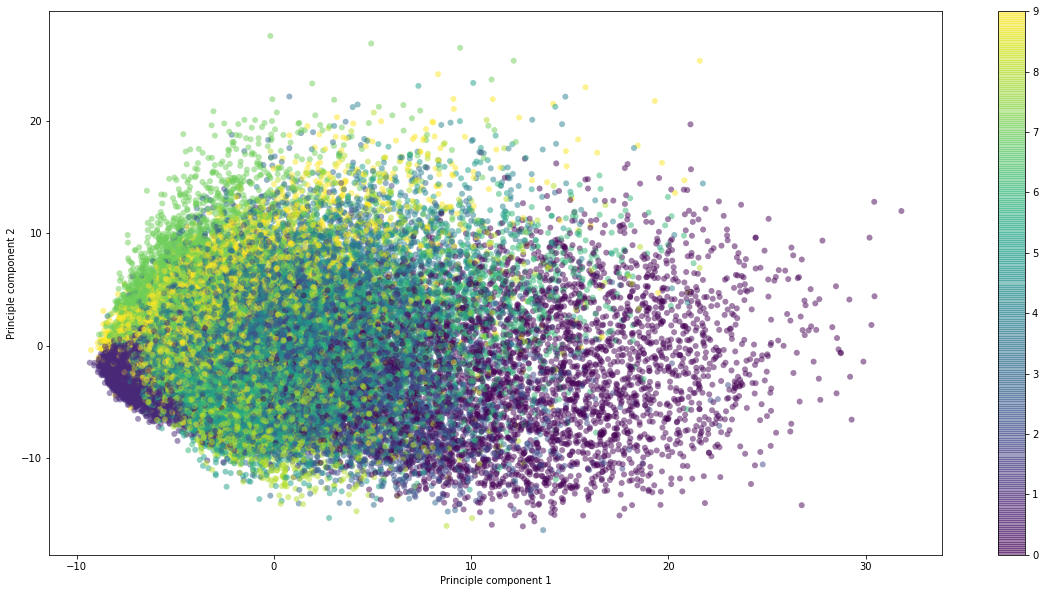

In [ ]:
# Plot each observation in terms of the two principle components,
# each seperated by class label

plt.figure(figsize=(20,10))
plt.scatter(projected[:, 0], projected[:, 1],
            c=y_train, edgecolor='none', alpha=0.5)
plt.xlabel('Principle component 1')
plt.ylabel('Principle component 2')
plt.colorbar()
plt.show()

Next, we plot each of the observations in terms of the two principle components, but for each of the class labels. It seems that these two calculated principle components do not seperate the classes as well as expected, except for maybe labels 1. This is perhaps due to the data not being
entirely suitable for using a dimensionality reduction such as PCA, which requires data to have a multinormal distribution.

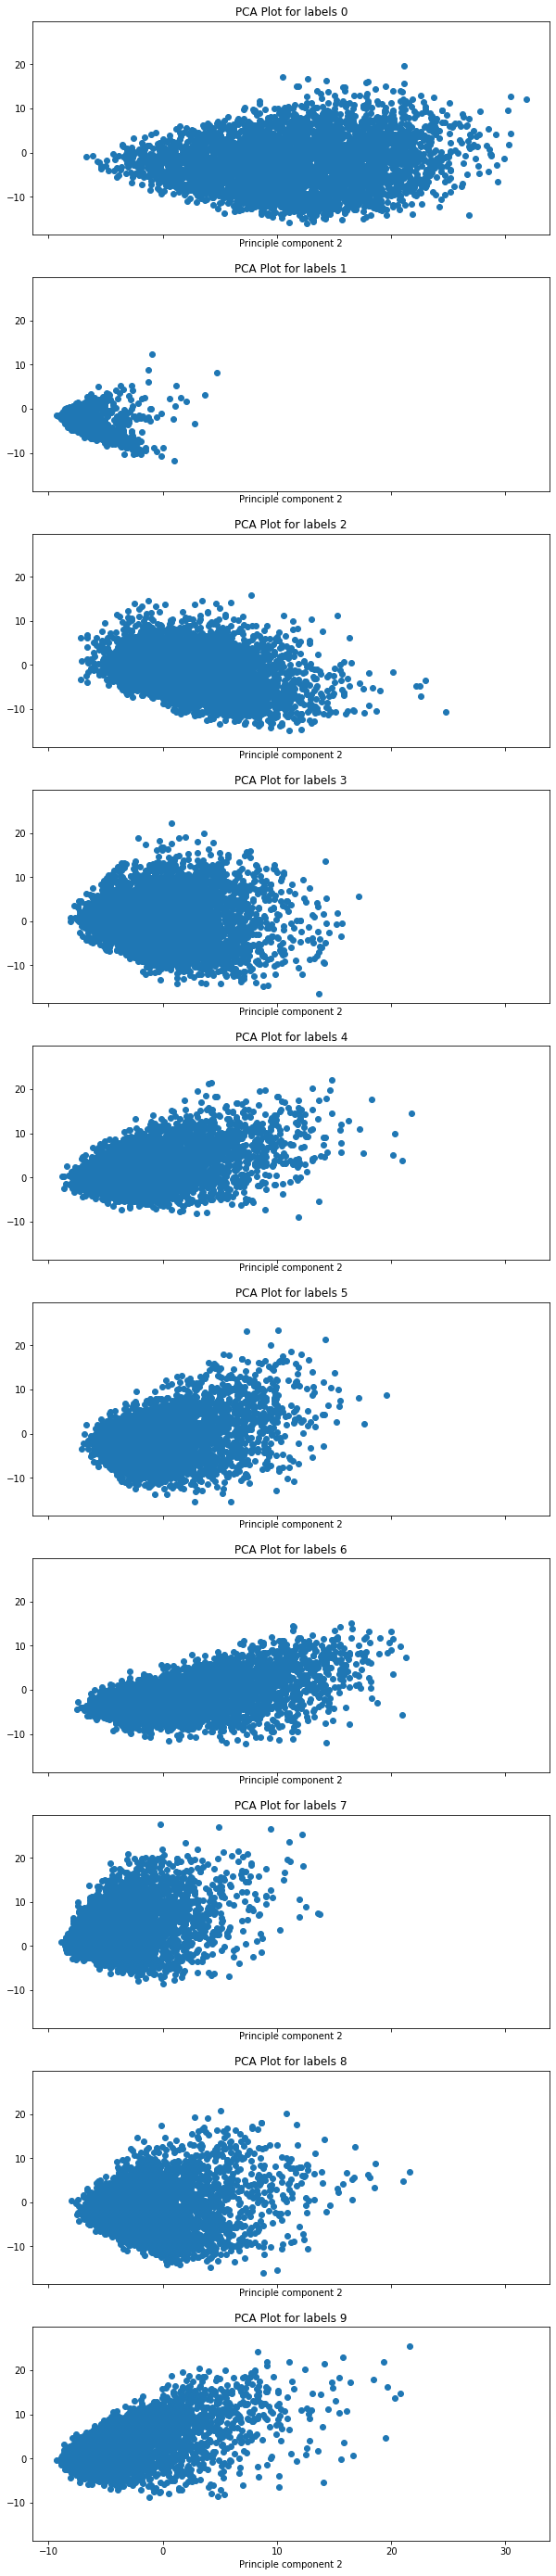

In [ ]:
# Plot each observation in terms of the two principle components
# for each of the class labels.
# Note how these two principle components do not seperate the classes
# as well as hoped. 

fig, axs = plt.subplots(10, sharex=True, sharey=True, figsize=(10,50))
for element in range(0,10):
  indices = [i for i, x in enumerate(y_train) if x == element]
  axs[element].scatter(projected[indices,0],projected[indices,1])
  axs[element].set_title("PCA Plot for labels {}".format(element))
  axs[element].set_xlabel("Principle component 1")
  axs[element].set_xlabel("Principle component 2")
plt.show()

Below we consider using more than 2 principle components. The scree plot shows we need ~200 principle components in order to capture 80% of the explained variance. Obviously, we can't visualise the 200 dimensions for each principle component. But instead, we will use the same architecture of a neural network above, but instead using these 200 principle components, in order to classify the handwritten digits.

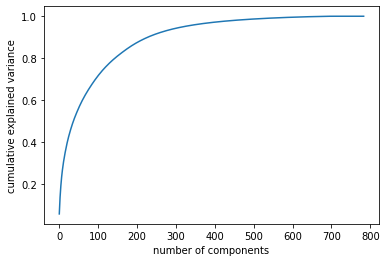

In [ ]:
pca = PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca_200 = PCA(n_components=200)
projected_200 = pca_200.fit_transform(x_train)

# Comparing autoencoders with an autoencoder-based PCA model.

### What is an autoencoder?

Much like PCA, an autoencoder is an unsupervised dimensionality reduction technique. Unlike PCA, it uses deep learning techniques to accomplish this, allowing for non-linear feature representations to be learned via the non-linear activations present in the network. \\
The autoencoder learns to copy its input to its output, and does this via two critical features of the network: the encoder and decoder. The encoder can be thought as the dimensionality reduction part of the network - it compresses the original feature space down to a smaller feature space. The decoder learns to do the opposite, it upscales this reduced feature space back up to try and restructure the original input of the network.

### Methodology of an autoencoder

The encoder and decoder of the network can be represented as functions, denoted $\phi$ and $\psi$ respectively:
\begin{align}
&\phi: X \rightarrow \mathcal{F} \\
&\psi: \mathcal{F} \rightarrow X
\end{align}
where $\phi$ and $\psi$ are optimised to minimise the mean-squared error between the original input $X$ and the composited input $\psi(\phi(X))$:
\begin{equation}
\phi,\psi = \arg_{\phi , \psi} \min ||X - \psi(\phi(X))||^2.
\end{equation}
Here, $\mathcal{F}$ represents the latent representation of the input.

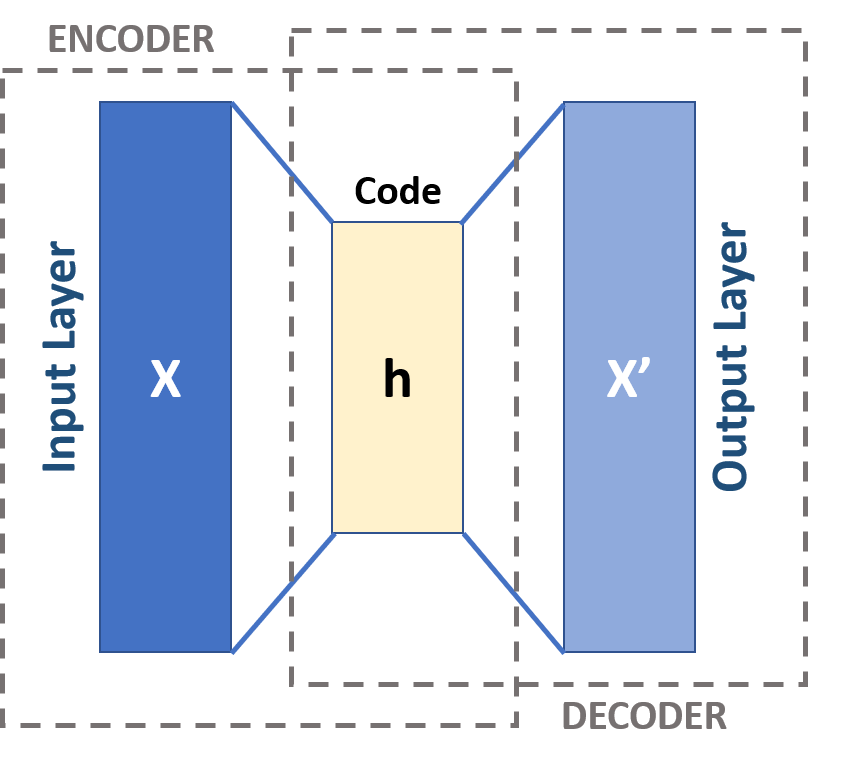

Source: https://en.wikipedia.org/wiki/Autoencoder#/media/File:Autoencoder_schema.png

### Relation between PCA and autoencoders

An autoencoder with a single hidden layer and no non-linear activations can be considered similar to what PCA is trying to achieve.

In [ ]:
# Import dataset
batch_size = 128

# Convert the data to Tensor and normalise by the mean and std  of the data set
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

# Import and normalize the train set in mini-batches 
train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_set_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                              shuffle=True)

# Import and normalize the test set in mini-batches
test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                              shuffle=True)

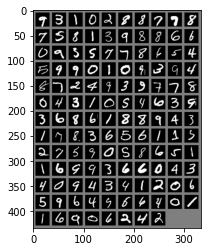

In [ ]:
# Import libraries for visualising
import matplotlib.pyplot as plt
import numpy as np

# Load a batch of training images for visualising
data_iterator = iter(train_set_loader)
images, labels = data_iterator.next()

# Create function for visualisation
def show_image(img):
    # revert the normalisation for displaying the images in their original form
    img = img * 0.5 + 0.5
    # Convert to numpy for visualisation
    npimg = img.numpy()
    # Plot each image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# Plot images as a grid using the 'make_grid' function
show_image(torchvision.utils.make_grid(images,10,5))
plt.show()

In [ ]:
class autoencoder_PCA(nn.Module):
    def __init__(self,num_in,num_hidden_1,num_out):
        super(autoencoder_PCA, self).__init__()
        # The layers of the encoder
        self.encoder = nn.Linear(num_in, num_hidden_1) 
        # The layers of the decoder   
        self.decoder = nn.Linear(num_hidden_1, num_out) 

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class layer_2_autoencoder(nn.Module):
    def __init__(self,num_in,num_hidden_1,num_hidden_2,num_out):
        super(layer_2_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_in, num_hidden_1),
            nn.ReLU(True),
            nn.Linear(num_hidden_1, num_hidden_2))  
        self.decoder = nn.Sequential(
            nn.Linear(num_hidden_2, num_hidden_1),
            nn.ReLU(True), 
            nn.Linear(num_hidden_1, num_out), 
            nn.Tanh())
           
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class layer_3_autoencoder(nn.Module):
    def __init__(self,num_in,num_hidden_1,num_hidden_2,num_hidden_3,num_out):
        super(layer_3_autoencoder, self).__init__()
        # The layers of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(num_in, num_hidden_1),
            nn.ReLU(True),
            nn.Linear(num_hidden_1, num_hidden_2),
            nn.ReLU(True),
            nn.Linear(num_hidden_2, num_hidden_3))
        # The layers of the dencoder
        self.decoder = nn.Sequential(
            nn.Linear(num_hidden_3, num_hidden_2),
            nn.ReLU(True),
            nn.Linear(num_hidden_2, num_hidden_1),
            nn.ReLU(True),
            nn.Linear(num_hidden_1, num_out),
            nn.Tanh())
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train(train_set, batch_size, num_epochs, learning_rate, model):

    no_batches = int(np.round((len(train_set) / batch_size)))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

    losses = []
    for epoch in range(num_epochs):
        train_loss = 0
        for data in train_set_loader:
            img, _ = data
            img = img.view(img.size(0), -1)
            img = Variable(img)
            
            # =================== forward pass =====================
            output = model(img)
            loss = criterion(output, img)
            
            # =================== backward pass ====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #train_loss += loss.data[0]
            train_loss += loss.item()
            
            # =================== log ========================
        print('====> Epoch: {} Average loss: {:.4f}'.format(
               epoch, train_loss / no_batches))
        losses.append(train_loss / no_batches)   
    return losses

In [ ]:
def evaluate_test(test_set, test_set_loader, batch_size, model):
    
    test_loss = 0
    criterion = nn.MSELoss()
    test_no_batches = np.round(int(len(test_set)/batch_size))
    
    for data in test_set_loader:
            img, _ = data
            img = img.view(img.size(0), -1)
            img = Variable(img)
            
            # =================== forward pass =====================
            output = model(img)
            loss = criterion(output, img)
            test_loss += loss.item()
            #test_loss += loss.data[0]
            
        # =================== log ========================
    test_loss = test_loss/test_no_batches
    print('====> Test loss: {:.4f}'.format(test_loss))
    return test_loss

====> Epoch: 0 Average loss: 0.2916
====> Epoch: 1 Average loss: 0.1591
====> Epoch: 2 Average loss: 0.1303
====> Epoch: 3 Average loss: 0.1192
====> Epoch: 4 Average loss: 0.1151
====> Epoch: 5 Average loss: 0.1139
====> Epoch: 6 Average loss: 0.1136
====> Epoch: 7 Average loss: 0.1134
====> Epoch: 8 Average loss: 0.1133
====> Epoch: 9 Average loss: 0.1133
====> Epoch: 10 Average loss: 0.1133
====> Epoch: 11 Average loss: 0.1132
====> Epoch: 12 Average loss: 0.1132
====> Epoch: 13 Average loss: 0.1132
====> Epoch: 14 Average loss: 0.1132
====> Epoch: 15 Average loss: 0.1131
====> Epoch: 16 Average loss: 0.1132
====> Epoch: 17 Average loss: 0.1130
====> Epoch: 18 Average loss: 0.1130
====> Epoch: 19 Average loss: 0.1130
====> Epoch: 20 Average loss: 0.1129
====> Epoch: 21 Average loss: 0.1129
====> Epoch: 22 Average loss: 0.1129
====> Epoch: 23 Average loss: 0.1128
====> Epoch: 24 Average loss: 0.1127
====> Epoch: 25 Average loss: 0.1127
====> Epoch: 26 Average loss: 0.1126
====> Epoch

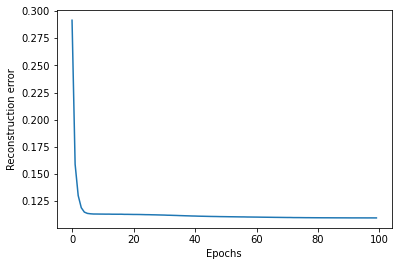

====> Test loss: 0.1093


In [ ]:
# define the model
num_input=28*28
num_hidden_1=16
num_output=28*28
model1 = autoencoder_PCA(num_input,num_hidden_1,num_output)

# train the model
model1_loss_train = train(train_set= train_set, batch_size = 128, num_epochs = 100, learning_rate=1e-3, model = model1)

# Plot the training error
fig = plt.figure()
plt.plot(model1_loss_train)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

# Calculate the loss in test set
model1_loss_test= evaluate_test(test_set = test_set, test_set_loader=  test_set_loader,batch_size = 128, model=model1)

Visualise reconstruction of images

====> Epoch: 0 Average loss: 0.2456
====> Epoch: 1 Average loss: 0.1372
====> Epoch: 2 Average loss: 0.1249
====> Epoch: 3 Average loss: 0.1207
====> Epoch: 4 Average loss: 0.1195
====> Epoch: 5 Average loss: 0.1180
====> Epoch: 6 Average loss: 0.1167
====> Epoch: 7 Average loss: 0.1146
====> Epoch: 8 Average loss: 0.1130
====> Epoch: 9 Average loss: 0.1112
====> Epoch: 10 Average loss: 0.1087
====> Epoch: 11 Average loss: 0.1049
====> Epoch: 12 Average loss: 0.1012
====> Epoch: 13 Average loss: 0.0995
====> Epoch: 14 Average loss: 0.0984
====> Epoch: 15 Average loss: 0.0975
====> Epoch: 16 Average loss: 0.0966
====> Epoch: 17 Average loss: 0.0958
====> Epoch: 18 Average loss: 0.0949
====> Epoch: 19 Average loss: 0.0942
====> Epoch: 20 Average loss: 0.0936
====> Epoch: 21 Average loss: 0.0931
====> Epoch: 22 Average loss: 0.0927
====> Epoch: 23 Average loss: 0.0911
====> Epoch: 24 Average loss: 0.0901
====> Epoch: 25 Average loss: 0.0890
====> Epoch: 26 Average loss: 0.0880
====> Epoch

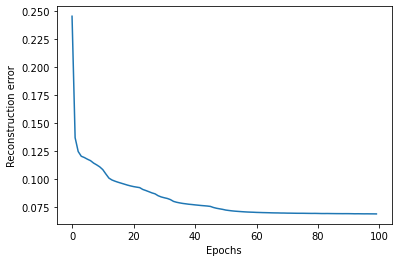

====> Test loss: 0.0683


In [ ]:
#define the model
num_input=28*28
num_hidden_1=32
num_hidden_2=16
num_output=28*28

model2 = layer_2_autoencoder(num_input,num_hidden_1,num_hidden_2,num_output)

#train the model
model2_loss_train = train(train_set= train_set, batch_size = 128, num_epochs = 100, learning_rate=1e-3, model = model2)

# Plot the error 
fig = plt.figure()
plt.plot(model2_loss_train)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

#calculate the loss in test set
model2_loss_test= evaluate_test(test_set = test_set, test_set_loader=  test_set_loader,batch_size = 128, model=model2)

====> Epoch: 0 Average loss: 0.1409
====> Epoch: 1 Average loss: 0.0601
====> Epoch: 2 Average loss: 0.0448
====> Epoch: 3 Average loss: 0.0374
====> Epoch: 4 Average loss: 0.0333
====> Epoch: 5 Average loss: 0.0304
====> Epoch: 6 Average loss: 0.0281
====> Epoch: 7 Average loss: 0.0265
====> Epoch: 8 Average loss: 0.0251
====> Epoch: 9 Average loss: 0.0239
====> Epoch: 10 Average loss: 0.0230
====> Epoch: 11 Average loss: 0.0222
====> Epoch: 12 Average loss: 0.0216
====> Epoch: 13 Average loss: 0.0208
====> Epoch: 14 Average loss: 0.0203
====> Epoch: 15 Average loss: 0.0198
====> Epoch: 16 Average loss: 0.0193
====> Epoch: 17 Average loss: 0.0190
====> Epoch: 18 Average loss: 0.0186
====> Epoch: 19 Average loss: 0.0183
====> Epoch: 20 Average loss: 0.0181
====> Epoch: 21 Average loss: 0.0178
====> Epoch: 22 Average loss: 0.0176
====> Epoch: 23 Average loss: 0.0174
====> Epoch: 24 Average loss: 0.0173
====> Epoch: 25 Average loss: 0.0171
====> Epoch: 26 Average loss: 0.0170
====> Epoch

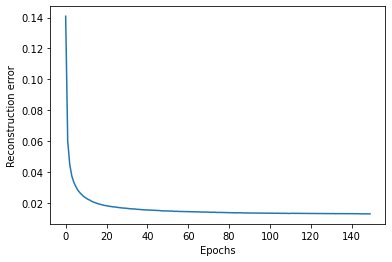

====> Test loss: 0.0133


In [ ]:
#define the model
num_input=28*28
num_hidden_1=512
num_hidden_2=256
num_hidden_3=128
num_output=28*28

model3 = layer_3_autoencoder(num_input,num_hidden_1,num_hidden_2,num_hidden_3,num_output)

#train the model
model3_loss_train = train(train_set= train_set, batch_size = 128, num_epochs = 50, learning_rate=1e-3, model = model3)

# Plot the error 
fig = plt.figure()
plt.plot(model3_loss_train)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

#calculate the loss in test set
model3_loss_test= evaluate_test(test_set = test_set, test_set_loader=  test_set_loader,batch_size = 128, model=model3)

In [ ]:
data_iterator = iter(test_set_loader)
images, labels = data_iterator.next()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

def visualise_output(images, model):
    data =images
    img = data
    img = img.view(img.size(0), -1)
    img = Variable(img)
    out = model(img)
    pic = out.data.view(out.data.size(0), 1, 28, 28)
    pic = pic * 0.5 + 0.5
    np_pic = torchvision.utils.make_grid(pic[1:50], 10, 5).numpy()
    plt.imshow(np.transpose(np_pic, (1, 2, 0)))
    plt.show()

Original images


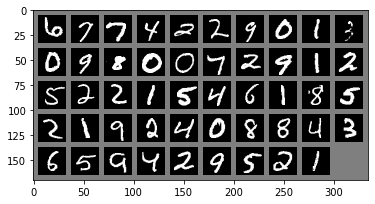

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PCA based autoencoder reconstruction:


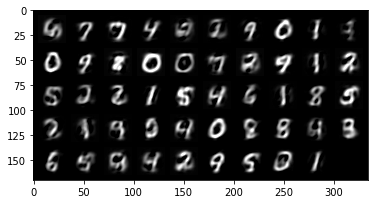

2-layer autoencoder reconstruction:


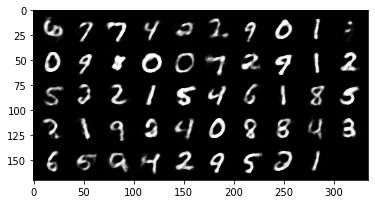

3-layer autoencoder reconstruction:


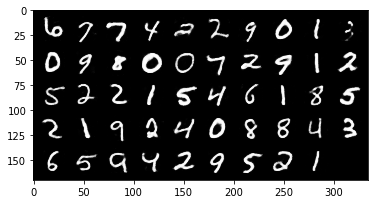

In [ ]:
# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the first model
print('PCA based autoencoder reconstruction:')
visualise_output(images, model1)

# Reconstruct and visualise the images using the second model
print('2-layer autoencoder reconstruction:')
visualise_output(images, model2)

# Reconstruct and visualise the images using the third model
print('3-layer autoencoder reconstruction:')
visualise_output(images, model3)